In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# ------------ The Parameters ----------#
v_bar = 1   # mean value of utility
var = 1     # variance of value function
price = 0   # price
T = 1000    # periods
S = 150     # subperiods
gamma = 1   # CRRA para
L = 20      # string length
J = 30      # population size
MIN = -4    # min value of alpha
MAX = 4     # max value of alpha
seq = [0,1] # possible bit in a string
iniPOP = 100 # initial population size
iniMUT = 0.08  # mutation rate

# mutation rate decays exponentially with rate gMUT
endMUT = 0.02
gMUT = (endMUT/iniMUT)**(1/T) - 1

In [3]:
# ------------ The Model ----------#

""" a class of portfolios to store attributes"""
class Portfolio():
    # Constructor
    def __init__(self, ruleStr):
        self.ruleStr = ruleStr
        self.alpha, self.s = self.find_values(self.ruleStr)
        self.V = self.update_V(self.s)

    # represent a portfolio
    def __str__(self):
        return self.ruleStr

    # get the alpha of a portfolio
    def find_values(self, ruleStr):
        # find alpha from the rule String
        alpha = MIN
        for j in range(len(ruleStr)):
            x = int(ruleStr[j])*(2**(j-1))/(2**(L - 1))
            alpha += (MAX-MIN)*x
        
        # find s from the rule String and alpha
        s = alpha*(v_bar - price)
        return alpha, s

    # find value V from the rule String and s
    def update_V(self, s):
        V = 0
        for i in range(S):
            d = random.gauss(v_bar, var)
            w = s*(d-price)
            u = -1*np.exp(-gamma*w)
            V += u
        return V

NameError: name 'self' is not defined

In [ ]:
# ------------ The GA Algorithm ----------#

""" define a function to select the best parents based on the fitness threshold """
def fitness_select(portfolioList, n_candidate):
    # sort the portfolios based on their payoff
    candidates = []
    for portfolio in portfolioList:
        portfolio.update_V(portfolio.s)
    sorted_portfolioList = sorted(portfolioList,key= lambda portfolio: portfolio.V, reverse=True)
    # select the first n candidates
    for i in range(n_candidate):
        candidates.append(sorted_portfolioList[i])
    return candidates

def parent_select(candidates, n_parents):
    # list of selected parents
    parents = []
    non_parents = []
    # sort the portfolios based on their payoff
    sorted_candidates = sorted(candidates, key= lambda candidate: candidate.V, reverse=True)
    # select the first n parents
    for i in range(n_parents):
        parents.append(sorted_candidates[i])
    for i in range(n_parents, n_parents + 6):
        non_parents.append(sorted_candidates[i])
    return parents, non_parents

""" define a function to perform crossover between 2 parents string """
def crossover(parent1, parent2):
    """
    :param parent1: string
    :param parent2: string
    :return: child1, child2
    """
    # define the length of the parents string
    length = len(parent1)
    # define the child strings
    child1 = ""
    child2 = ""
    # define the crossover point
    cross_point = random.randint(0, length-1)
    # define the child strings
    child1 = parent1[0:cross_point] + parent2[cross_point:length]
    child2 = parent2[0:cross_point] + parent1[cross_point:length]
    child1 = str(child1)
    child2 = str(child2)
    return child1, child2

""" define a function to perform mutation on a child string """
def mutate(child, MUT):
    """
    :param child: string
    :return: mutated child string
    """
    # define the length of the child string
    length = len(child)
    # define the mutated child string
    mutated_child = ""
    for bit in child:
        if random.uniform(0,1) < MUT:
            if bit == "1":
                mutated_child += "0"
            else:
                mutated_child += "1"
        else:
            mutated_child += bit
    return str(mutated_child)

""" define a function to perform genetic algorithm """
def ga_update(population, n_candidate, n_parents, mutation_rate):
    # select the best 30 portfolios for ga
    candidates = fitness_select(population, n_candidate)
    parents, non_parents = parent_select(candidates, n_parents)
    # retain the parents in the new popuation
    new_portfolioList = parents + non_parents
    # shuffle the parents
    parents_pairs = random.sample(parents, len(parents))
    # perform ga crossover and mutation to create new list of children strings
    children_list = []
    for i in range(0, n_parents, 2):
        child1, child2 = crossover(parents_pairs[i].ruleStr, parents_pairs[i+1].ruleStr)
        mutated_child1 = mutate(child1)
        mutated_child2 = mutate(child2)
        children_list.append(mutated_child1)
        children_list.append(mutated_child2)
    for i in range(len(children_list)):
        new_portfolioList.append(Portfolio(children_list[i]))
    return new_portfolioList

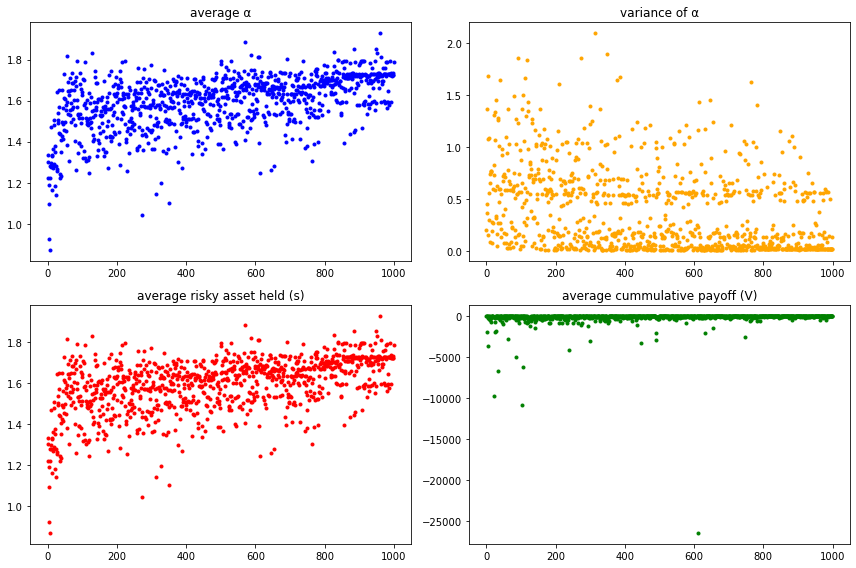

In [ ]:
# ------------ The Simulation ----------#

# a function to create a random population of string
def gen_pop(string_length):
    ruleStr = ''
    for i in range(string_length):
        ruleStr+=str(random.choice(seq))
    return ruleStr

# initialize a random population of portfolios
portfolioList = []
for i in range(iniPOP):
    ruleStr = gen_pop(L)
    portfolioList.append(Portfolio(ruleStr))

# prepare plot elements
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
marker = '.'
# runs the simulation for T times
for t in range(T):
    MUT = iniMUT*((1+gMUT)**t)
    portfolioList = ga_update(portfolioList, 30, 12, MUT)
    #extract average parameters
    alphaList = [portfolio.alpha for portfolio in portfolioList]
    alphaMean = sum(alphaList)/len(alphaList)
    alphaVar = np.var(alphaList)
    sList = [portfolio.s for portfolio in portfolioList]
    sMean = sum(sList)/len(sList)
    vList = [portfolio.V for portfolio in portfolioList]
    vMean = sum(vList)/S
    #plot
    ax1.scatter(t, alphaMean, color='blue', marker=marker)
    ax2.scatter(t, alphaVar, color='orange', marker=marker)
    ax3.scatter(t, sMean, color='red', marker=marker)
    ax4.scatter(t, vMean, color='green', marker=marker)

ax1.set_title('average α')
ax2.set_title('variance of α')
ax3.set_title('average risky asset held (s)')
ax4.set_title('average cummulative payoff (V)')
plt.tight_layout()